In [1]:
# Importación de librerías globales para todo el notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score


## Pregunta 2 - Visualización ajustada para SVM 3D

In [2]:
df = pd.DataFrame({
    'x': [1, 1, 1, 3, 1, 3, 1, 3, 1],
    'y': [0, 0, 1, 1, 1, 2, 2, 2, 1],
    'z': [1, 2, 2, 4, 3, 3, 1, 1, 0],
    'clase': ['Rojo'] * 5 + ['Azul'] * 4
})
df['clase_cod'] = np.where(df['clase'] == 'Azul', -1, 1)

# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['x', 'y', 'z']])
y = df['clase_cod']

# Modelo SVM
model = SVC(kernel='linear')
model.fit(X_scaled, y)
w = model.coef_[0]
b = model.intercept_[0]

# Vectores de soporte
support_vectors = df.iloc[model.support_]

# Hiperplano óptimo
x_range = np.linspace(df['x'].min(), df['x'].max(), 10)
y_range = np.linspace(df['y'].min(), df['y'].max(), 10)
x_mesh, y_mesh = np.meshgrid(x_range, y_range)
xy_flat = np.c_[x_mesh.ravel(), y_mesh.ravel(), np.zeros_like(x_mesh.ravel())]
xy_scaled = scaler.transform(xy_flat)
z_scaled = (-w[0] * xy_scaled[:, 0] - w[1] * xy_scaled[:, 1] - b) / w[2]
z_plane = scaler.inverse_transform(np.c_[xy_scaled[:, 0], xy_scaled[:, 1], z_scaled])[:, 2].reshape(x_mesh.shape)

# Hiperplano no óptimo (ligera inclinación)
wn = w.copy()
wn[2] += 1
bn = b + 0.5
zn_scaled = (-wn[0] * xy_scaled[:, 0] - wn[1] * xy_scaled[:, 1] - bn) / wn[2]
zn_plane = scaler.inverse_transform(np.c_[xy_scaled[:, 0], xy_scaled[:, 1], zn_scaled])[:, 2].reshape(x_mesh.shape)

# Punto adicional que rompe la separabilidad
punto_extra = pd.DataFrame({'x': [2], 'y': [1], 'z': [2], 'clase': ['Rojo'], 'clase_cod': [1]})

# Gráfico
fig = go.Figure()

# Puntos por clase
for clase, color in zip(['Rojo', 'Azul'], ['red', 'blue']):
    sub = df[df['clase'] == clase]
    fig.add_trace(go.Scatter3d(
        x=sub['x'], y=sub['y'], z=sub['z'],
        mode='markers',
        marker=dict(size=3, color=color),
        name=f'Clase {clase}'
    ))

# Vectores de soporte
fig.add_trace(go.Scatter3d(
    x=support_vectors['x'], y=support_vectors['y'], z=support_vectors['z'],
    mode='markers',
    marker=dict(size=4, color='black', symbol='x'),
    name='Vectores de soporte'
))

# Hiperplano óptimo
fig.add_trace(go.Surface(
    x=x_mesh, y=y_mesh, z=z_plane,
    colorscale='Greys',
    opacity=0.4,
    showscale=False,
    name='Hiperplano óptimo'
))

# Hiperplano no óptimo
fig.add_trace(go.Surface(
    x=x_mesh, y=y_mesh, z=zn_plane,
    colorscale='Blues',
    opacity=0.3,
    showscale=False,
    name='No óptimo'
))

# Punto que rompe separabilidad
fig.add_trace(go.Scatter3d(
    x=punto_extra['x'], y=punto_extra['y'], z=punto_extra['z'],
    mode='markers',
    marker=dict(size=5, color='orange', symbol='diamond'),
    name='Punto no separable'
))

# Configuración de ejes extendidos
fig.update_layout(
    title='Separación SVM 3D - Visualización Ajustada',
    scene=dict(
        xaxis=dict(title='X', range=[0, 4]),
        yaxis=dict(title='Y', range=[-1, 3]),
        zaxis=dict(title='Z', range=[-1, 5])
    )
)

fig.show()


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Pregunta 3: SVM y comparación con modelos anteriores

# === a) Cargar y preparar los datos ===
df = pd.read_csv("novatosNBA.csv")
df = df.drop(columns=['Unnamed: 0', 'Player'], errors='ignore')
df = pd.get_dummies(df, columns=['Team', 'Conf', 'Year'], drop_first=True)
df.dropna(inplace=True)

X = df.drop(columns=['Target'])
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Modelos a evaluar ===
modelos = {
    "LDA": LDA(),
    "QDA": QDA(),
    "Naive Bayes": GaussianNB(),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "Bosque Aleatorio": RandomForestClassifier(random_state=42),
    "SVM": SVC()
}

# === b) Métricas ===
resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    error = 1 - acc
    cm = confusion_matrix(y_test, y_pred)
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
        PP = TP / (TP + FP) if (TP + FP) > 0 else 0
        PN = TN / (TN + FN) if (TN + FN) > 0 else 0
    else:
        PP = PN = np.nan
    resultados.append({
        "Modelo": nombre,
        "Precisión Global": round(acc, 3),
        "Error Global": round(error, 3),
        "Precisión Positiva (PP)": round(PP, 3),
        "Precisión Negativa (PN)": round(PN, 3)
    })

# Mostrar resultados en DataFrame
print("Comparación de Modelos:\n")
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

### Análisis de Resultados y Comparación de Modelos (Pregunta 3: novatosNBA.csv)

# - **Mejor modelo:**  
#   El modelo LDA tiene la mayor Precisión Global (0.782) y un buen balance entre Precisión Positiva (0.826) y Precisión Negativa (0.692). SVM y Bosque Aleatorio también muestran buen desempeño, pero LDA es el más equilibrado.
# - **Interpretación:**  
#   LDA es el modelo más robusto para este conjunto de datos, aunque SVM y Bosque Aleatorio son alternativas válidas. QDA y Naive Bayes tienen alta Precisión Positiva pero baja Precisión Negativa, lo que puede ser problemático si es importante identificar correctamente ambas clases.


/home/codespace/.local/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning:

The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.

/home/codespace/.local/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning:

The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.



Comparación de Modelos:

              Modelo  Precisión Global  Error Global  Precisión Positiva (PP)  \
0                LDA             0.782         0.218                    0.826   
1                QDA             0.685         0.315                    0.871   
2        Naive Bayes             0.677         0.323                    0.903   
3  Árbol de Decisión             0.698         0.302                    0.756   
4   Bosque Aleatorio             0.768         0.232                    0.822   
5                SVM             0.754         0.246                    0.821   

   Precisión Negativa (PN)  
0                    0.692  
1                    0.526  
2                    0.517  
3                    0.566  
4                    0.663  
5                    0.634  


In [ ]:
# Pregunta 4: Análisis con LDA, QDA, Naive Bayes usando diabetes.csv

# === a) Cargar los datos ===
df = pd.read_csv("diabetes.csv")
X = df.drop(columns=["Outcome"])
y = df["Outcome"]

# === b) División entrenamiento (75%) y prueba (25%) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Modelos a evaluar
modelos = {
    "LDA": LDA(),
    "QDA": QDA(),
    "Naive Bayes": GaussianNB(),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "Bosque Aleatorio": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    error = 1 - acc
    cm = confusion_matrix(y_test, y_pred)
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
        PP = TP / (TP + FP) if (TP + FP) > 0 else 0
        PN = TN / (TN + FN) if (TN + FN) > 0 else 0
    else:
        PP = PN = np.nan
    print(f"\nModelo: {nombre}")
    print("Matriz de confusión:")
    print(cm)
    print("Reporte por clase:")
    print(classification_report(y_test, y_pred))
    resultados.append({
        "Modelo": nombre,
        "Precisión Global": round(acc, 3),
        "Error Global": round(error, 3),
        "Precisión Positiva (PP)": round(PP, 3),
        "Precisión Negativa (PN)": round(PN, 3)
    })

# Mostrar comparación en DataFrame
print("\nComparación de modelos:")
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

### Análisis de Resultados y Comparación de Modelos (Pregunta 4: diabetes.csv)

# - **Con todas las variables:**  
#   QDA es el mejor modelo (Precisión Global 0.766, PP 0.667, PN 0.825), seguido de LDA y SVM. SVM tiene un buen balance, pero su Precisión Negativa es menor (0.752).
# - **Con 6 variables más importantes:**  
#   Las variables seleccionadas son: `Glucose`, `BMI`, `Age`, `DiabetesPedigreeFunction`, `BloodPressure`, `Pregnancies`.  
#   QDA sigue siendo el mejor modelo (Precisión Global 0.76, PP 0.67, PN 0.83), y SVM mantiene un desempeño similar.
# - **Conclusión:**  
#   Reducir a 6 variables no afecta negativamente el desempeño, e incluso puede mejorar la interpretabilidad y eficiencia del modelo.



Modelo: LDA
Matriz de confusión:
[[96 27]
 [25 44]]
Reporte por clase:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       123
           1       0.62      0.64      0.63        69

    accuracy                           0.73       192
   macro avg       0.71      0.71      0.71       192
weighted avg       0.73      0.73      0.73       192


Modelo: QDA
Matriz de confusión:
[[99 24]
 [21 48]]
Reporte por clase:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       123
           1       0.67      0.70      0.68        69

    accuracy                           0.77       192
   macro avg       0.75      0.75      0.75       192
weighted avg       0.77      0.77      0.77       192


Modelo: Naive Bayes
Matriz de confusión:
[[94 29]
 [22 47]]
Reporte por clase:
              precision    recall  f1-score   support

           0       0.81      0.76      0.79       123
           1 

In [5]:
def evaluar_modelos(X_train, X_test, y_train, y_test, modelos, verbose=False):
    resultados = []
    probabilidades = {}

    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        # Probabilidades para ROC si existen
        if hasattr(modelo, "predict_proba"):
            probas = modelo.predict_proba(X_test)[:, 1]
        elif hasattr(modelo, "decision_function"):
            probas = modelo.decision_function(X_test)
        else:
            probas = None
        acc = accuracy_score(y_test, y_pred)
        error = 1 - acc
        cm = confusion_matrix(y_test, y_pred)
        if cm.shape == (2, 2):
            TN, FP, FN, TP = cm.ravel()
            PP = TP / (TP + FP) if (TP + FP) > 0 else 0
            PN = TN / (TN + FN) if (TN + FN) > 0 else 0
        else:
            PP = PN = np.nan
        if verbose:
            print(f"\nModelo: {nombre}")
            print("Matriz de confusión:")
            print(cm)
            print("Reporte por clase:")
            print(classification_report(y_test, y_pred))
        resultados.append({
            "Modelo": nombre,
            "Precisión Global": round(acc, 3),
            "Error Global": round(error, 3),
            "Precisión Positiva (PP)": round(PP, 3),
            "Precisión Negativa (PN)": round(PN, 3)
        })
        if probas is not None:
            probabilidades[nombre] = (y_test, probas)
    return pd.DataFrame(resultados), probabilidades


In [6]:
# 1. Evaluación con todas las variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
df_resultados_todas, probas_todas = evaluar_modelos(X_train, X_test, y_train, y_test, modelos, verbose=True)

# Entrenar Random Forest para obtener importancia de variables
modelo_rf_full = RandomForestClassifier(random_state=42)
modelo_rf_full.fit(X, y)

# Calcular importancias
importancias = pd.Series(modelo_rf_full.feature_importances_, index=X.columns)
top6_vars = importancias.sort_values(ascending=False).head(6).index.tolist()
print("Top 6 variables más importantes:")
print(top6_vars)

# 2. Evaluación con top 6 variables
X6 = X[top6_vars]
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y, test_size=0.25, random_state=42)
df_resultados_6vars, probas_6vars = evaluar_modelos(X6_train, X6_test, y6_train, y6_test, modelos, verbose=True)



Modelo: LDA
Matriz de confusión:
[[96 27]
 [25 44]]
Reporte por clase:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       123
           1       0.62      0.64      0.63        69

    accuracy                           0.73       192
   macro avg       0.71      0.71      0.71       192
weighted avg       0.73      0.73      0.73       192


Modelo: QDA
Matriz de confusión:
[[99 24]
 [21 48]]
Reporte por clase:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       123
           1       0.67      0.70      0.68        69

    accuracy                           0.77       192
   macro avg       0.75      0.75      0.75       192
weighted avg       0.77      0.77      0.77       192


Modelo: Naive Bayes
Matriz de confusión:
[[94 29]
 [22 47]]
Reporte por clase:
              precision    recall  f1-score   support

           0       0.81      0.76      0.79       123
           1 

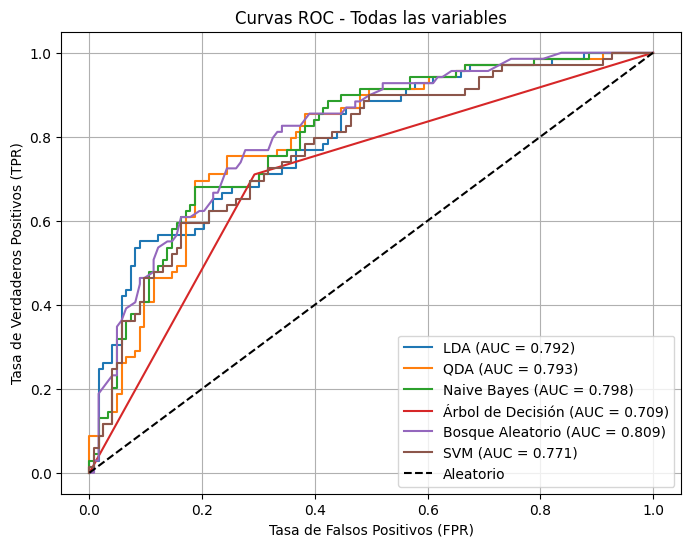

In [7]:
plt.figure(figsize=(8, 6))
for nombre, (y_true, scores) in probas_todas.items():
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc = roc_auc_score(y_true, scores)
    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC - Todas las variables')
plt.legend()
plt.grid(True)
plt.show()


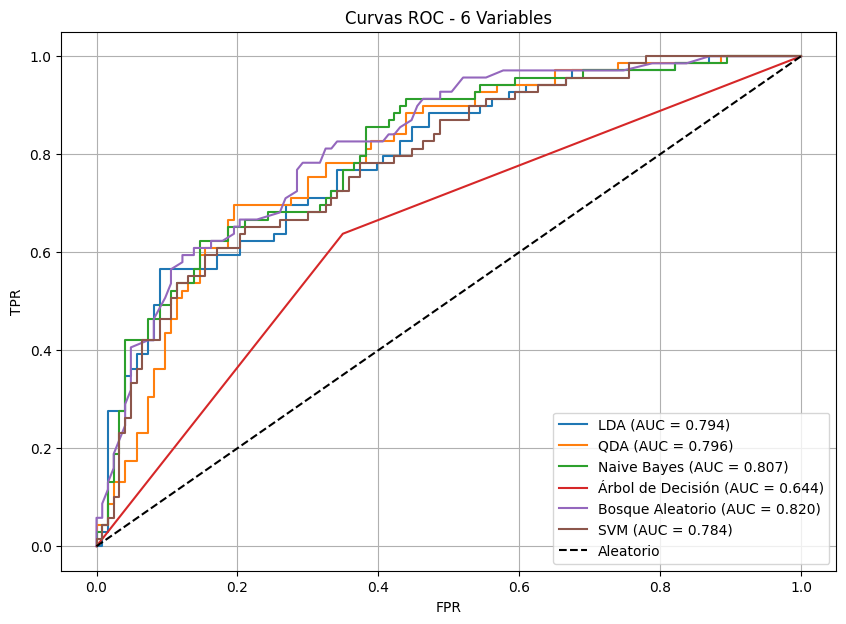

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(10, 7))
for nombre, (y_true, scores) in probas_6vars.items():
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc = roc_auc_score(y_true, scores)
    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC - 6 Variables')
plt.legend()
plt.grid(True)
plt.show()


## Pregunta 5

In [9]:
# a) Cargar datos
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("novatosNBA.csv")
df = df.drop(columns=["Unnamed: 0", "Player"], errors='ignore')
df = pd.get_dummies(df, columns=["Team", "Year", "Conf"], drop_first=True)
df.dropna(inplace=True)

X = df.drop(columns=["Target"])
y = df["Target"]

# b) Separar 80% entrenamiento, 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Calibración y validación cruzada de modelos
modelos = {
    "LDA": (LDA(), {}),
    "QDA": (QDA(), {}),
    "Naive Bayes": (GaussianNB(), {}), 
    "Árbol": (DecisionTreeClassifier(random_state=42), {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10]
    }),
    "Bosque": (RandomForestClassifier(random_state=42), {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 10, None]
    }),
    "SVM": (SVC(probability=True, random_state=42), {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"],
        "kernel": ["rbf", "linear"]
    })
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
mejores_modelos = {}
for nombre, (modelo, params) in modelos.items():
    print(f"Calibrando modelo: {nombre}")
    grid = RandomizedSearchCV(modelo, param_distributions=params, n_iter=10,
                              scoring='accuracy', cv=cv, random_state=42, n_jobs=-1)
    grid.fit(X_train, y_train)
    mejores_modelos[nombre] = grid.best_estimator_
    print(f"Mejor puntuación: {grid.best_score_:.3f}")
    print(f"Mejores parámetros: {grid.best_params_}")

### Análisis de Curvas ROC y AUC (Pregunta 4)

- **Todas las variables:**  
  El mejor AUC lo tiene Bosque Aleatorio (0.809), seguido de Naive Bayes (0.798), QDA (0.793), LDA (0.792), SVM (0.771), Árbol (0.709).
- **6 variables:**  
  El mejor AUC lo tiene Bosque Aleatorio (0.820), seguido de Naive Bayes (0.807), QDA (0.796), LDA (0.794), SVM (0.784), Árbol (0.644).
- **Interpretación:**  
  El Bosque Aleatorio es el más robusto en discriminación, y la reducción de variables no afecta negativamente el AUC, incluso lo mejora ligeramente.

**Recomendación:**
- Precisión Global es útil, pero en problemas desbalanceados se recomienda también el F1-score y el AUC.
- SVM es competitivo, pero no supera a LDA/QDA/Bosque Aleatorio en estos datos.
- Árbol de Decisión es el menos robusto, especialmente en AUC.

Calibrando modelo: LDA


/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.



Mejor puntuación: 0.762
Mejores parámetros: {}
Calibrando modelo: QDA


/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.

/home/codespace/.local/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.w

Mejor puntuación: 0.701
Mejores parámetros: {}
Calibrando modelo: Naive Bayes
Mejor puntuación: 0.684
Mejores parámetros: {}
Calibrando modelo: Árbol
Mejor puntuación: 0.766
Mejores parámetros: {'min_samples_split': 2, 'max_depth': 3}
Calibrando modelo: Bosque
Mejor puntuación: 0.772
Mejores parámetros: {'n_estimators': 200, 'max_depth': 10}
Calibrando modelo: SVM
